# 네이버 영화리뷰 감성분석

## (1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.tail()

,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


## (2) 데이터로더 구성

* IMDB 데이터셋과 달리 nsmc데이터셋은 가공이 안되어있으므로 imdb.ata_loader()와 같은 것을 만들어야 함.
1. 데이터의 중복치 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(Stopword)제거
5. 사전 word_to_index 구성
6. 텍스트 스트링을 사전인덱스 스트링으로 변환
7. 트레인 테스트셋, word_to_index

In [6]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
# 단어: 번호 순으로 된걸 뒤집음
index_to_word = {index:word for word, index in word_to_index.items()}

** 인코딩은 위에 있는거같은데**

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [73]:
x_train[0].shape

(41,)

In [67]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 뭥미 . .. 대체 무슨 생각 이런 걸 만든 건지 모르 겠 다 ; 시간 낭비 . .. 취향 제대로 탈 듯 . .. 모든 게 너무 조악 하 고 너무 유치 해 ㅠㅠ
라벨:  0


## (3) 모델구성을 위한 데이터 분석 및 가공

In [9]:
train_data.shape[0]+test_data.shape[0]

195341

In [10]:
len(X_train)

146182

In [11]:
len(X_test)

49157

In [12]:
# 텍스트데이터 문장길이의 리스트를 생성
total_data_text = list(X_train) + list(X_test)

In [13]:
# NaN을 제외한
len(total_data_text)

195339

* 적절한 문장의 길이 구하기

In [14]:
# 문장길이의 평균값, 최대값, 표준편차를 구한다.
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
#평균, 최대값, 표준편차 계산
print(np.mean(num_tokens))
print(np.max(num_tokens))
print(np.std(num_tokens))

15.96938143432699
116
12.843571939469296


In [15]:
# 최대길이를 (평균+2 * 표준편차)로
max_tokens = np.mean(num_tokens)+2*np.std(num_tokens)
maxlen = int(max_tokens)
maxlen

41

In [16]:
print('전체 문장의 {}가 maxlen 설정값 이내에 포함됩니다. '
      .format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

전체 문장의 0.9342988343341575가 maxlen 설정값 이내에 포함됩니다. 


* 패딩시퀀스(문장의 길이 맞춤) - maxlen 41줄로

In [17]:
X_train_pad = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_pad = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

## (4) 모델 훈련

* 사용데이터 최종 정리

In [18]:
vocab_size = 10000
word_vector_dim = 41

In [19]:
round(len(X_train_pad)*2/10) # 29200사용

29236

In [20]:
# val set
x_val = X_train_pad[:29200]
y_val = y_train[:29200]
# train set
x_train = X_train_pad[29200:]
y_train = y_train[29200:]

print(x_train.shape)
print(y_train.shape)

(116982, 41)
(116982,)


In [21]:
x_val.shape,y_val.shape

((29200, 41), (29200,))

### model 1 (IMDB실습과 비슷한 모델)

In [22]:
model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1600      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 20epochs 실행결과 3부터 차이커짐

In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10 # 몇 epoch훈련이 좋은가 결과보며 변경해보기
history = model.fit(x_train, y_train, epochs=epochs, batch_size=512,
                    validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
229/229 [==============================] - 2s 9ms/step - loss: 0.5256 - accuracy: 0.7585 - val_loss: 0.3891 - val_accuracy: 0.8432
Epoch 2/10
229/229 [==============================] - 2s 8ms/step - loss: 0.3465 - accuracy: 0.8565 - val_loss: 0.3504 - val_accuracy: 0.8500
Epoch 3/10
229/229 [==============================] - 2s 8ms/step - loss: 0.3124 - accuracy: 0.8720 - val_loss: 0.3443 - val_accuracy: 0.8532
Epoch 4/10
229/229 [==============================] - 2s 8ms/step - loss: 0.2938 - accuracy: 0.8812 - val_loss: 0.3422 - val_accuracy: 0.8536
Epoch 5/10
229/229 [==============================] - 2s 8ms/step - loss: 0.2771 - accuracy: 0.8887 - val_loss: 0.3410 - val_accuracy: 0.8557
Epoch 6/10
229/229 [==============================] - 2s 8ms/step - loss: 0.2599 - accuracy: 0.8970 - val_loss: 0.3492 - val_accuracy: 0.8545
Epoch 7/10
229/229 [==============================] - 2s 8ms/step - loss: 0.2435 - accuracy: 0.9037 - val_loss: 0.3545 - val_accuracy: 0.8537
Epoch 

In [25]:
results = model.evaluate(X_test_pad,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3990 - accuracy: 0.8443
[0.3990454077720642, 0.8442744612693787]


### model  2 (CNNv1d)

In [26]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [27]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10 # 몇 epoch훈련이 좋은가 결과보며 변경해보기
history2 = model2.fit(x_train, y_train, epochs=epochs, batch_size=124,
                    validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
944/944 [==============================] - 11s 12ms/step - loss: 0.4072 - accuracy: 0.8074 - val_loss: 0.3332 - val_accuracy: 0.8558
Epoch 2/10
944/944 [==============================] - 5s 5ms/step - loss: 0.2893 - accuracy: 0.8792 - val_loss: 0.3242 - val_accuracy: 0.8609
Epoch 3/10
944/944 [==============================] - 5s 6ms/step - loss: 0.2213 - accuracy: 0.9135 - val_loss: 0.3474 - val_accuracy: 0.8556
Epoch 4/10
944/944 [==============================] - 5s 5ms/step - loss: 0.1518 - accuracy: 0.9446 - val_loss: 0.4122 - val_accuracy: 0.8507
Epoch 5/10
944/944 [==============================] - 4s 5ms/step - loss: 0.1019 - accuracy: 0.9650 - val_loss: 0.5030 - val_accuracy: 0.8468
Epoch 6/10
944/944 [==============================] - 5s 5ms/step - loss: 0.0707 - accuracy: 0.9764 - val_loss: 0.5814 - val_accuracy: 0.8393
Epoch 7/10
944/944 [==============================] - 5s 5ms/step - loss: 0.0541 - accuracy: 0.9822 - val_loss: 0.6730 - val_accuracy: 0.8354
Epoc

In [28]:
results2 = model2.evaluate(X_test_pad,  y_test, verbose=2)

print(results2)

1537/1537 - 4s - loss: 0.8267 - accuracy: 0.8286
[0.8266577124595642, 0.8285900354385376]


### model 3 - Maxpoolinglayer 1개만 사용

In [29]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 41)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 336       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


In [30]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10 # 몇 epoch훈련이 좋은가 결과보며 변경해보기
history3 = model3.fit(x_train, y_train, epochs=epochs, batch_size=124,
                    validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
944/944 [==============================] - 4s 5ms/step - loss: 0.4305 - accuracy: 0.8115 - val_loss: 0.3454 - val_accuracy: 0.8479
Epoch 2/10
944/944 [==============================] - 4s 4ms/step - loss: 0.3120 - accuracy: 0.8686 - val_loss: 0.3379 - val_accuracy: 0.8528
Epoch 3/10
944/944 [==============================] - 4s 4ms/step - loss: 0.2705 - accuracy: 0.8896 - val_loss: 0.3438 - val_accuracy: 0.8537
Epoch 4/10
944/944 [==============================] - 4s 4ms/step - loss: 0.2360 - accuracy: 0.9063 - val_loss: 0.3594 - val_accuracy: 0.8534
Epoch 5/10
944/944 [==============================] - 4s 4ms/step - loss: 0.2066 - accuracy: 0.9203 - val_loss: 0.3814 - val_accuracy: 0.8497
Epoch 6/10
944/944 [==============================] - 4s 4ms/step - loss: 0.1795 - accuracy: 0.9323 - val_loss: 0.4114 - val_accuracy: 0.8465
Epoch 7/10
944/944 [==============================] - 4s 4ms/step - loss: 0.1552 - accuracy: 0.9426 - val_loss: 0.4406 - val_accuracy: 0.8415
Epoch 

In [31]:
results3 = model3.evaluate(X_test_pad,  y_test, verbose=2)
print(results3)

1537/1537 - 2s - loss: 0.5700 - accuracy: 0.8282
[0.5699579119682312, 0.8282442092895508]


## (5) loss, accuracy 시각화

In [32]:
# history.history 딕셔너리 형태
history_dict = history.history
history_dict2 = history2.history
history_dict3 = history3.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [33]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
acc2 = history_dict2['accuracy']
acc3 = history_dict3['accuracy']

val_acc = history_dict['val_accuracy']
val_acc2 = history_dict2['val_accuracy']
val_acc3 = history_dict3['val_accuracy']

loss = history_dict['loss']
loss2 = history_dict2['loss']
loss3 = history_dict3['loss']

val_loss = history_dict['val_loss']
val_loss2 = history_dict2['val_loss']
val_loss3 = history_dict3['val_loss']

epochs = range(1,len(acc)+1) # lenacc = 현재 20 (1,20)이므로 (1,21)해야 20까지 나옴

* loss graph

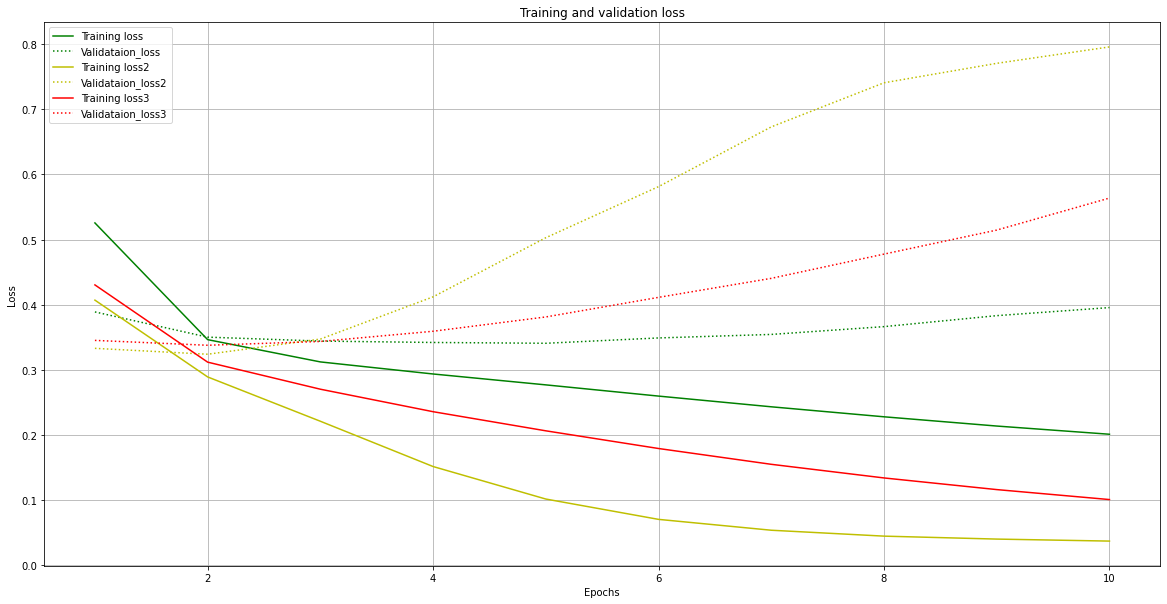

In [37]:
plt.plot(epochs, loss,'g-', label = 'Training loss')
plt.plot(epochs, val_loss,'g:', label='Validataion_loss')
plt.plot(epochs, loss2, 'y-', label = 'Training loss2')
plt.plot(epochs, val_loss2,'y:', label='Validataion_loss2')
plt.plot(epochs, loss3, 'r-', label = 'Training loss3')
plt.plot(epochs, val_loss3,'r:', label='Validataion_loss3')
plt.title('Training and validation loss')

plt.rcParams["figure.figsize"] = (20,10)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()


plt.show()

* accuracy graph

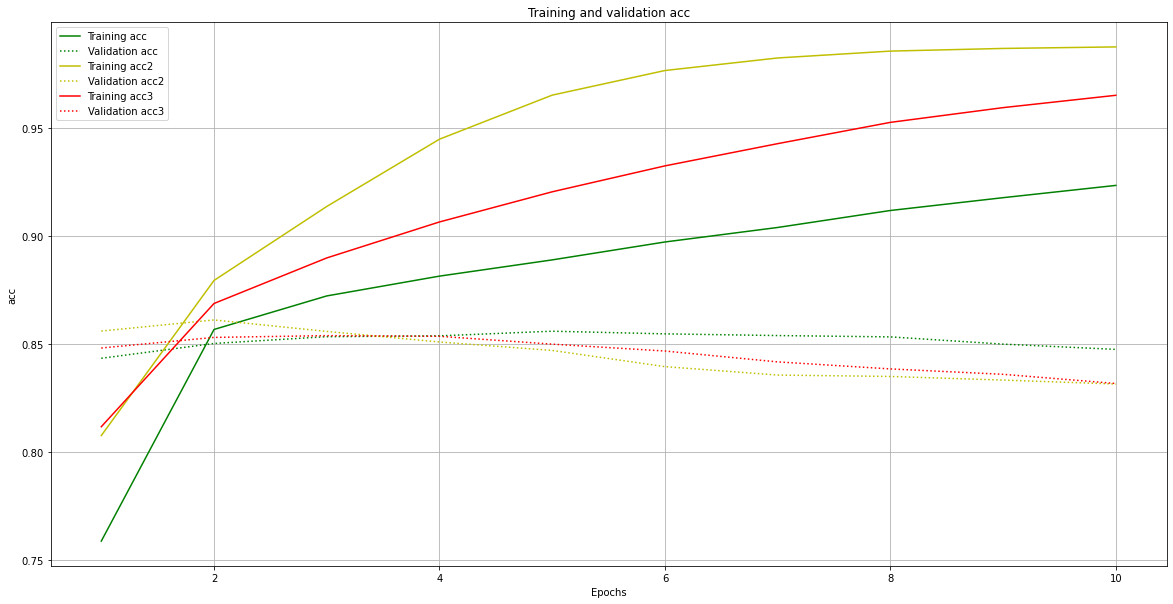

In [38]:
plt.plot(epochs, acc,'g-', label = 'Training acc')
plt.plot(epochs, val_acc,'g:', label='Validation acc')
plt.plot(epochs, acc2, 'y-', label = 'Training acc2')
plt.plot(epochs, val_acc2,'y:', label='Validation acc2')
plt.plot(epochs, acc3, 'r-', label = 'Training acc3')
plt.plot(epochs, val_acc3,'r:', label='Validation acc3')
plt.title('Training and validation acc')

plt.rcParams["figure.figsize"] = (20,10)
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.grid()
plt.legend()


plt.show()

* loss, acc 모두 낮은 epoch에서 비슷한 수치를 유지하다가 학습이 진행될 수록 오버피팅?이 발생했다. acc도 85근처로 90이상을 원했는데 만족스럽지 않다.

## (6) 학습된 Embedding layer분석

* 모델의 임베딩 레이어에서 weight를 가져옴

In [39]:
# model의 첫번째 layer가 임베딩레이어임
# model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


* 1번째 단어의 word2vec결과

In [51]:
weights[0]

array([ 0.00881387,  0.06291465,  0.01877097,  0.00796767,  0.03520044,
        0.01778967,  0.00548065, -0.01046995, -0.06842739, -0.01388497,
       -0.00946632, -0.05060071,  0.02548887, -0.15900408, -0.01813384,
       -0.02935122, -0.05019925,  0.02772343, -0.06378287,  0.02421084,
       -0.05789846, -0.03053093, -0.03628182,  0.0110943 ,  0.00171683,
        0.01696362, -0.02576784,  0.18655828, -0.04228434,  0.03491387,
        0.04100617,  0.00433224, -0.03610105,  0.02807436,  0.0512603 ,
       -0.00032347, -0.04726715, -0.08565458,  0.00440666, -0.00327727,
        0.0083308 ], dtype=float32)

In [ ]:
## model.get_weights() == 단어의 의미를 나타내는 벡터 (훈련한 파라미터값)

* 이 코드는 어렵다.

In [48]:
model.get_weights()[0]

array([[ 8.81386921e-03,  6.29146472e-02,  1.87709741e-02, ...,
         4.40665800e-03, -3.27726803e-03,  8.33080150e-03],
       [ 1.84191391e-03,  3.86586525e-02,  2.43699551e-03, ...,
        -3.64846364e-02, -1.94390770e-02, -1.67835504e-04],
       [-4.78815287e-03,  3.47478315e-02, -4.98263277e-02, ...,
         3.44337337e-03, -1.05586713e-02, -6.89809956e-03],
       ...,
       [-1.57669373e-02, -1.19259477e-01,  1.98153198e-01, ...,
        -3.60641144e-02, -1.65326536e-01,  1.05713665e-01],
       [ 9.86033082e-02, -1.26773775e-01,  1.11534446e-01, ...,
        -7.62116611e-02, -9.50482935e-02,  9.48969275e-02],
       [-6.67343289e-03, -4.48502190e-02,  9.51120406e-02, ...,
        -7.75671611e-03, -1.80810168e-02, -4.57421541e-02]], dtype=float32)

In [47]:
model.get_weights()[0].shape

(10000, 41)

In [54]:
index_to_word[4]

'.'

In [55]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_ex.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0] # 모델의 가중치
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :]))))) ## ??
f.close()

In [63]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False) 

In [74]:
word_vectors.similar_by_word("사랑")

[('이제서야', 0.9122577905654907),
 ('놓칠', 0.9083559513092041),
 ('훌쩍', 0.9078362584114075),
 ('뿌듯', 0.9066042304039001),
 ('돌파', 0.9021356701850891),
 ('갈증', 0.9018605947494507),
 ('비범', 0.9013082981109619),
 ('게이트', 0.9009705185890198),
 ('후유증', 0.8997436761856079),
 ('푹', 0.8989970684051514)]

* 비슷한 단어라고 내놓은 것들이 상당히 부족해보인다. 모델의 정확도가 85% 수준이지만 뭔가 문제가 많아보인다,

## (8) 한국어 Word2Vec Embedding 이용해 성능개선

In [119]:
vocab_size = 10000
word_vector_dim = 200

In [ ]:
## utf-8 이슈 발생
## -아닐 경우-
## Keyedvector를 가져와서 그 파라미터를 모델에 넣고 훈련하려했으나 실패
## word2vec도 실패

In [136]:
# 다른 모델의 weight 사용하기
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
f1 = open(word2vec_path,'r', encoding="UTF8")

for line in f1:
    print(line)
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 200개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))



UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [137]:
word2vec_kor = Word2Vec.load(word2vec_path)

In [138]:
word2vec_kor['한국'],word2vec_kor['한국'].shape

/home/ssac26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(array([ 4.16339219e-01, -1.25663519e+00,  2.63531923e+00,  2.26872540e+00,
         4.52816971e-02, -4.47537303e-02,  9.51993346e-01, -2.65543666e-02,
        -5.99260151e-01,  9.88520384e-01, -9.79172587e-01,  1.96647871e+00,
         5.99487901e-01,  9.28627551e-01, -5.57144225e-01, -3.85925353e-01,
         8.81565571e-01,  2.05469322e+00,  2.30629563e+00,  8.88094604e-01,
        -1.34726211e-01,  7.23809421e-01, -3.62861693e-01,  9.56575871e-01,
         1.06285739e+00, -5.84842682e-01,  1.79322705e-01, -1.64163542e+00,
        -6.85926974e-01,  1.90222645e+00, -8.29897046e-01,  6.82858303e-02,
        -1.18628168e+00,  6.74696505e-01, -1.90387058e+00, -3.69383240e+00,
         2.01234841e+00,  1.60147563e-01,  6.87842131e-01, -6.95778549e-01,
        -1.41536549e-01, -1.70556533e+00,  4.76975322e-01,  4.25297648e-01,
        -1.95409787e+00, -1.02384269e+00,  1.23789036e+00, -1.48075604e+00,
        -3.19255471e-01, -3.04880172e-01, -8.32104325e-01, -1.10666126e-01,
        -5.1

In [125]:
model = keras.Sequential()


model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.set_weights(word2vec_kor)
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 
model.summary()

TypeError: object of type 'Word2Vec' has no len()

In [ ]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# epochs = 10 # 몇 epoch훈련이 좋은가 결과보며 변경해보기
# history = model.fit(x_train, y_train, epochs=epochs, batch_size=512,
#                     validation_data=(x_val, y_val), verbose=1)

In [ ]:
# results = model.evaluate(X_test_pad,  y_test, verbose=2)

# print(results)